#Rentrenamiento del modelo CNN-LSTM-MLP

En este notebook, se rentrenará el tercer mejor modelo, que en la primera vez de la etapa de entrenamiento de marzo del 2023 fue seleccionado dentro de los tres mejores modelos. En marzo del 2023, este modelo obtuvo 85.53% de accuracy en el conjunto Testing. Asimismo, fue necesario rentrenar los tres mejores modelos con la finalidad de generar los subconjunto de registros con las clases predichas en el conjunto Testing a fin de aplicar el efecto causal.

## Instalación de la librerías keras-preprocessing

In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


## Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import pickle
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
import io
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Fijar semillas

Con la finalidad de mitigar posibles sesgos fijamos las semillas antes de cualquier operación que involucre aleatoriedad como el tokenizador, inicializacion de pesos durante el entrenamiento, con lo cual se permitirá que cualquier aleatoriedad durante el proceso sea controlado y reproducible.

In [4]:
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Cargar los conjuntos de datos

### Corpus completo - 4014 registros

In [5]:
#Cargar el conjunto training con atributos recuperados
# Training_3130.xlsx'
from google.colab import files
uploaded = files.upload()

Saving sgc_4014.xlsx to sgc_4014.xlsx


In [6]:
#Asignar a una variable el contenido del conjunto de datos
sgc = io.BytesIO(uploaded['sgc_4014.xlsx'])
df_sgc4014 = pd.read_excel(sgc)
df_sgc4014.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,elecciones2021 apurímac respaldo a candidato p...,2882,2021-04-11,1,15,0
1,elecciones2021 pueblo libre adultos mayores aú...,1795,2021-06-06,1,35,1
2,elecciones2021 si fuiste elegido miembro de me...,3113,2021-04-09,1,23,0
3,elecciones2021 es importante mantenerte inform...,3305,2021-04-05,1,36,1
4,nuestros partidos políticos están tan dividido...,2878,2021-04-12,1,32,1


In [7]:
df_sgc4014.shape

(4014, 6)

In [8]:
df_sgc4014.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,2057
1,1957


### Conjunto Training - 3130 registros

In [9]:
#Cargar el conjunto training con atributos recuperados
# Training_3130.xlsx'
from google.colab import files
uploaded = files.upload()

Saving Training_3130.xlsx to Training_3130.xlsx


In [10]:
#Asignar a una variable el contenido del conjunto de datos
training = io.BytesIO(uploaded['Training_3130.xlsx'])
df_training = pd.read_excel(training)
df_training.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,elecciones2021 apurímac respaldo a candidato p...,2882,2021-04-11,1,15,0
1,elecciones2021 pueblo libre adultos mayores aú...,1795,2021-06-06,1,35,1
2,elecciones2021 si fuiste elegido miembro de me...,3113,2021-04-09,1,23,0
3,elecciones2021 es importante mantenerte inform...,3305,2021-04-05,1,36,1
4,nuestros partidos políticos están tan dividido...,2878,2021-04-12,1,32,1


In [11]:
df_training.shape

(3130, 6)

In [12]:
df_training.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,1604
1,1526


### Conjunto Validation - 200 registros

In [13]:
#Cargar el conjunto training con atributos recuperados
# Validation_200.xlsx'
from google.colab import files
uploaded = files.upload()

Saving Validation_200.xlsx to Validation_200.xlsx


In [14]:
#Asignar a una variable el contenido del conjunto de datos
validation = io.BytesIO(uploaded['Validation_200.xlsx'])
df_validation = pd.read_excel(validation)
df_validation.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,pedrocastillote estoy casi seguro q le ingresó...,1948,2021-12-17,1,46,1
1,paridad y alternancia desde defensoriaperu des...,465,2020-07-24,1,32,1
2,oficinas descentralizada de procesos electoral...,3202,2021-04-07,1,29,0
3,jurado nacional de elecciones registró 25 inci...,212,2020-11-29,1,16,0
4,video panorama elecciones2021 hernando de soto...,175,2020-12-07,1,14,0


In [15]:
df_validation.shape

(200, 6)

In [16]:
df_validation.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,102
1,98


### Conjunto Testing - 684 registros

In [17]:
#Cargar el conjunto testing con atributos recuperados
# Testing_684.xlsx'
from google.colab import files
uploaded = files.upload()

Saving Testing_684.xlsx to Testing_684.xlsx


In [18]:
#Asignar a una variable el contenido del conjunto de datos
testing = io.BytesIO(uploaded['Testing_684.xlsx'])
df_testing = pd.read_excel(testing)
df_testing.head()

,Tweet_Checked,Id,Fecha,Clase_Argumento,Word_quantity,Long_text
0,lima sur desde defensoriaperu demandamos respe...,191,2020-12-03,1,29,0
1,elecciones2021 el 10 de febrero es la fecha lí...,1122,2021-01-02,1,20,0
2,onpeinforma a partir de ahora compartiremos en...,2103,2021-04-13,1,28,0
3,último los titulares del jne la onpeoficial y ...,3639,2021-03-24,1,27,0
4,elecciones2021 lescano dice que sube en encues...,1228,2021-03-01,1,14,0


In [19]:
df_testing.shape

(684, 6)

In [59]:
df_testing.Clase_Argumento.value_counts()

,count
Clase_Argumento,
0,351
1,333


In [60]:
print(df_testing.Id)

0       191
1      1122
2      2103
3      3639
4      1228
       ... 
679    3913
680     519
681    1040
682    3792
683    3528
Name: Id, Length: 684, dtype: int64


## Gráficamente la distribución de los tres conjuntos de datos

### Conjunto Training

###### Distribution of training data #####


<Axes: ylabel='count'>

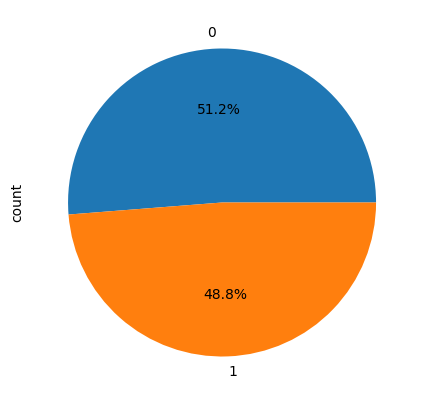

In [22]:
import matplotlib.pyplot as plt

print("###### Distribution of training data #####")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_training['Clase_Argumento'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)

### Conjunto Validation

###### Distribution of validation data #####


<Axes: ylabel='count'>

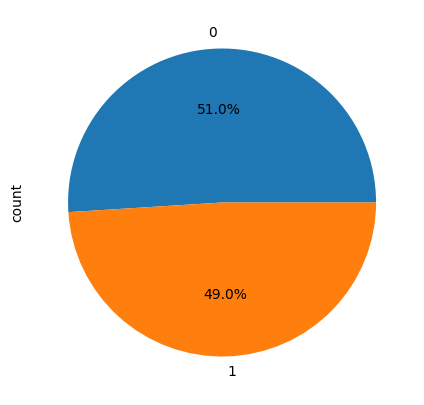

In [23]:
print("###### Distribution of validation data #####")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_validation['Clase_Argumento'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)

### Conjunto Testing

###### Distribution of testing data #####


<Axes: ylabel='count'>

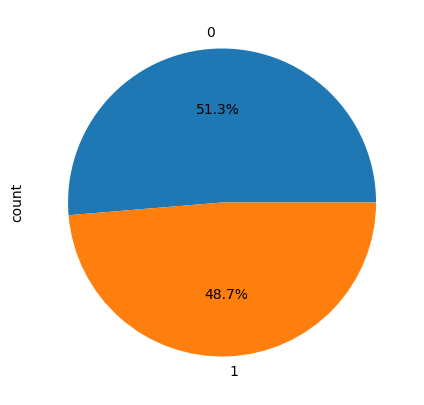

In [24]:
print("###### Distribution of testing data #####")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_testing['Clase_Argumento'].value_counts().plot.pie(autopct = '%1.1f%%')#, labels=labels)

## Vectorización de los datos

### Inicializamos los parámetros globales

In [25]:
max_nb_words = 60000
max_features = 11000 #Máximo número de palabras que formaran parte del diccionario
maxlen = 500 #Nro de tokens a partir del cual crearemos la secuencia del tweet
emb_dim = 200 #Tamaño del vector embedding

### Inicializamos el tokenizador para todo el corpus

In [26]:
tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_sgc4014['Tweet_Checked'].values)# tokenizer on whole training, testing and validation data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9984 unique tokens.


### Convertir a secuencias y aplicar padding

#### Al atributo "Tweet_Checked"

In [27]:
train_sequences = tokenizer.texts_to_sequences(df_training['Tweet_Checked'].values)
train_padded = pad_sequences(train_sequences, maxlen=maxlen)
print('Shape del tensor', train_padded.shape)

test_sequences = tokenizer.texts_to_sequences(df_testing['Tweet_Checked'].values)
test_padded = pad_sequences(test_sequences, maxlen=maxlen)
print('Shape del tensor', test_padded.shape)

val_sequences = tokenizer.texts_to_sequences(df_validation['Tweet_Checked'].values)
val_padded = pad_sequences(val_sequences, maxlen=maxlen)
print('Shape del tensor', val_padded.shape)

Shape del tensor (3130, 500)
Shape del tensor (684, 500)
Shape del tensor (200, 500)


#### A la clase: Clase_Argumento

In [28]:
Y_train = pd.get_dummies(df_training['Clase_Argumento']).values
print('Shape del tensor Y_train', Y_train.shape)

Y_test = pd.get_dummies(df_testing['Clase_Argumento']).values
print('Shape del tensor Y_test', Y_test.shape)

Y_val = pd.get_dummies(df_validation['Clase_Argumento']).values
print('Shape del tensor Y_val', Y_val.shape)

Shape del tensor Y_train (3130, 2)
Shape del tensor Y_test (684, 2)
Shape del tensor Y_val (200, 2)


## Cargar los embedding con Glove de SBWC

Vista que es un rentrenamiento del tercer mejor modelo, se usará el embedding que se uso en marzo del 2023 a fin de controlar un proceso de replicación sin sesgos o variaciones que podrían eventualmente cambiar los resultados por lo que se cargará desde mi google drive.

In [29]:
#Para conectar a mi Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
embedding_vectors = {}

with open('/content/gdrive/MyDrive/Tesis Doctoral PUCP/FASE II_CAUSAL METHODOLOGY/glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as file:
  for row in file:
    values = row.split(' ')
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vectors[word] = weights

print(f"Tamaño del vocabulario en Glove: {len(embedding_vectors)}")

Tamaño del vocabulario en Glove: 1193515


In [31]:
#initialize the embedding_matrix with zeros: Es necesario correrlo para que se ejecute la funcion "pretrained_embedding_layer"
emb_dim = 200 #200 es la dimensión del vector embedding SBWC
if max_nb_words is not None:
    vocab_len = max_nb_words
else:
    vocab_len = len(word_index)+1

embedding_matrix = np.zeros((vocab_len, emb_dim))

oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

        else:
            oov_count += 1
            oov_words.append(word)
#Check some of the out of vocabulary words
print(f'A few out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

A few out of valubulary words: ['elecciones2021', 'nuevaconstitucion', '11', 'onpeoficial', 'jneperu']
1761 out of 60000 words were OOV.


Vemos que 1761 palabras se encuentran como OOV de un total de 60,000 por lo que representa pequeño, aproximadamente 2,9% siendo aceptable para la mayoría de trabajos de NLP. Asimismo, los modelos CNN, CNN-LSTM, CNN-LSTM-MLP suelen mejorar adecuadamente términos OOV debido a su capacidad de generalización la cual fue evidenciada durante la primera vez que se entre los modelos DL en marzo del 2023.

## Implementación del modelo CNN-LSTM-MLP

In [32]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten
from keras.layers import Dropout, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from sklearn.metrics import confusion_matrix
from keras import initializers, layers, models, regularizers, constraints, optimizers
from keras.utils import to_categorical

#from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
import math

In [33]:
#Global variables
batch_size = 256 #Se obtiene mejores resultados con este valor de batch_size
epochs  = 25

### Función para detener el entrenamiento del modelo

In [34]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback

detener = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=5)

### Entrenamiento del modelo CNN-LSTM-MLP

In [35]:
#Arquitectura del modelo entrenado en marzo 2023
learning_rate=0.0001
nb = math.ceil(len(train_padded)/batch_size) # Nro de batches

def CNN_LSTM_MLP_model(embedding_matrix):
    emb_dim = embedding_matrix.shape[1]
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Embedding(vocab_len, emb_dim, weights=[embedding_matrix]))
    cnn_lstm_model.add(layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    cnn_lstm_model.add(layers.MaxPooling1D(5))
    cnn_lstm_model.add(LSTM(256, return_sequences=True))
    cnn_lstm_model.add(layers.LSTM(256))
    cnn_lstm_model.add(Dense(128, activation='relu'))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Dense(2, activation='softmax'))
    cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    #cnn_lstm_model.save_weights('cnn_lstm_mlp_model1.h5')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [36]:
cnn_lstm_mlp_model = CNN_LSTM_MLP_model(embedding_matrix)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      12,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,000,000 (45.78 MB)

 Trainable params: 12,000,000 (45.78 MB)

 Non-trainable params: 0 (0.00 B)

### Usaremos el método LearningRateScheduler de Keras

In [41]:
# Como estoy trabajando con Keras usaré el LearningRateScheduler que es simil de LrFinder de PyTorch
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr*np.exp(-0.1)

In [42]:
cnn_lstm_mlp_model.fit(train_padded, Y_train, batch_size=batch_size, callbacks=[LearningRateScheduler(lr_schedule)])

13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.5124 - loss: 0.6715 - learning_rate: 1.0000e-04


Vemos que se ha calculado el valor de learning_rate como: 1.0000e-04

### Compilamos nuevamente el modelo con el learning_rate calculado

In [43]:
print(learning_rate)

0.0001


In [44]:
cnn_lstm_mlp_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

### Rentrenamiento del modelo CNN-LSTM-MLP

In [45]:
history = cnn_lstm_mlp_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[detener])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - accuracy: 0.7168 - loss: 0.6009 - val_accuracy: 0.7900 - val_loss: 0.5072
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.7505 - loss: 0.5318 - val_accuracy: 0.8050 - val_loss: 0.4649
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.7689 - loss: 0.5000 - val_accuracy: 0.8000 - val_loss: 0.4481
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.7928 - loss: 0.4608 - val_accuracy: 0.7950 - val_loss: 0.4351
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.8025 - loss: 0.4292 - val_accuracy: 0.8150 - val_loss: 0.4312
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.8282 - loss: 0.4100 - val_accuracy: 0.8200 - val_loss: 0.4106
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.8390 - loss: 0.3779 - val_accuracy: 0.7800 - val_loss: 0.4050
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.8435 - loss: 0.3591 - val_accuracy: 0.7850 - val_l

### Funcion para los resultados accuracy de Testing

In [51]:
def train_test_accuracy(model,train_padded,Y_train,test_padded,Y_test):
  train_results = model.evaluate(train_padded, np.asarray(Y_train), verbose=0, batch_size=256)
  test_results = model.evaluate(test_padded, np.asarray(Y_test), verbose=0, batch_size=256)
  print(f'Train accuracy: {train_results[1] * 100:0.2f}')
  print(f'Test accuracy: {test_results[1] * 100:0.2f}')

In [52]:
#RESULTADOS
print("Obtained results with CNN-LSTM-MLP Model")
train_test_accuracy(cnn_lstm_mlp_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM-MLP Model
Train accuracy: 91.57
Test accuracy: 78.65


### Entrenaremos el learning_rate calculado con PyTorch en marzo 2023

In [53]:
#learning_rate calculado con PyTorch en marzo 2023: 0.0020309177
cnn_lstm_mlp_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0020309177), metrics=['accuracy'])

In [54]:
history = cnn_lstm_mlp_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[detener])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step - accuracy: 0.6070 - loss: 1.6363 - val_accuracy: 0.7750 - val_loss: 0.5867
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.6918 - loss: 0.6125 - val_accuracy: 0.7550 - val_loss: 0.5034
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.7619 - loss: 0.5196 - val_accuracy: 0.8000 - val_loss: 0.4643
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.8009 - loss: 0.4377 - val_accuracy: 0.8050 - val_loss: 0.4138
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.8959 - loss: 0.2567 - val_accuracy: 0.8500 - val_loss: 0.4336
Epoch 5: early stopping


In [55]:
#RESULTADOS
print("Obtained results with CNN-LSTM-MLP Model")
train_test_accuracy(cnn_lstm_mlp_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM-MLP Model
Train accuracy: 92.56
Test accuracy: 82.75


### Model Accuracy

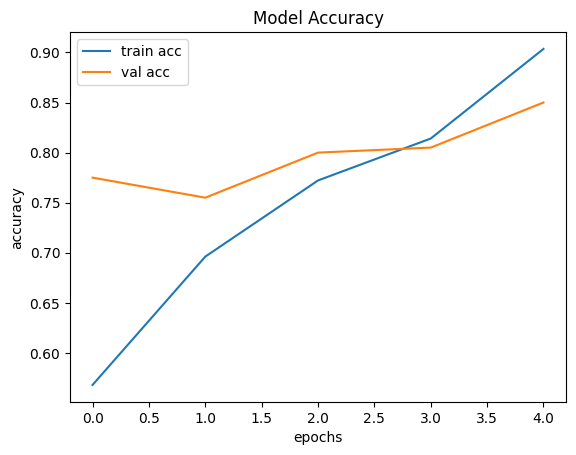

In [56]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

### Model Lost

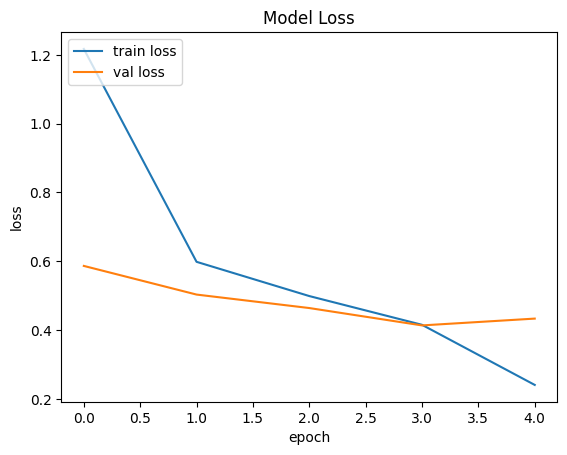

In [57]:
#plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

### Guardamos los pesos y el modelo

In [58]:
#Guardamos los pesos del modelo
cnn_lstm_mlp_model.save_weights('pesos_cnn_lstm_mlp_rentrenado.weights.h5')

#Guardamos el modelo completo
cnn_lstm_mlp_model.save('modelo_cnn_lstm_mlp_rentrenado.keras')

### Función: Reporte Métrica - Matriz Confusion - Guardar predicciones

In [61]:
#Función para calcular la PREDICCION con el modelo entrenado usando el conjunto datos testing
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

def reporte_clasificacion(model,test_padded,Y_test):
  model = model
  y_actuals = np.argmax(Y_test, axis=1) # Convertir Y_test a etiquetas

  #encoder.inverse_transform(a)
  y_preds = model.predict(test_padded)

  prediction_ = np.argmax(y_preds, axis=1) #Convertir predicciones a etiquetas

  y_preds = prediction_
  target_names = ['0', '1']
  report = classification_report(y_actuals.tolist(), y_preds.tolist(), target_names=target_names)
  print("Reporte de métricas")
  print(report)
  print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_actuals.tolist(), y_preds.tolist())))

  #Calcular la matriz de confusión
  cm = confusion_matrix(y_actuals, prediction_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

  #Visualizar y guardar la matriz de confusión
  disp.plot(cmap='Blues')
  plt.title("Matriz de confusión - Testing")
  plt.savefig("Matriz_confusion_testing.png")
  plt.show()

  #Decodificar las secuencias vectorizadas de los textos a los textos originales
  X_test_texts = [' '.join(tokenizer.index_word.get(word, '') for word in sequence if word !=0) for sequence in test_padded]

  #Crear el dataframe con las predicciones
  df_predictions_cnn_lstm_mlp = pd.DataFrame({
      'Id': df_testing.Id,
      'Texto': X_test_texts,
      'Fecha': df_testing.Fecha,
      'Etiqueta Real': y_actuals,
      'Etiqueta Predicha': prediction_
  }

  )

  #Guardar el dataframe a un archivos csv
  df_predictions_cnn_lstm_mlp.to_csv('predictions_testing_cnn_lstm_mlp.csv', index=False)
  print("Predicciones guardadas en 'predictions_testing_cnn_lstm_mlp.csv'")

  return df_predictions_cnn_lstm_mlp

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step
Reporte de métricas
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       351
           1       0.76      0.94      0.84       333

    accuracy                           0.83       684
   macro avg       0.84      0.83      0.83       684
weighted avg       0.85      0.83      0.83       684

accuracy: 0.827


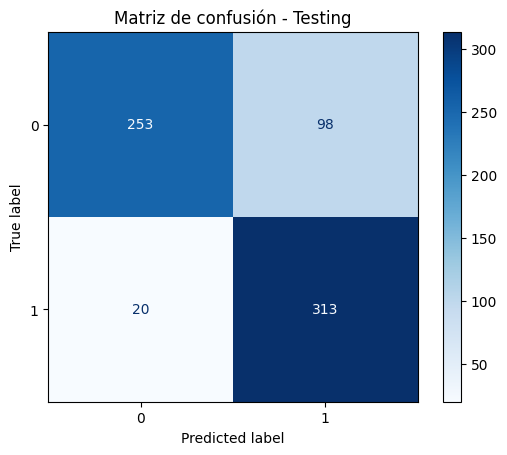

Predicciones guardadas en 'predictions_testing_cnn_lstm_mlp.csv'
     Id                                              Texto      Fecha  \
0   191  lima sur desde defensoriaperu demandamos respe... 2020-12-03   
1  1122  elecciones2021 el 10 de febrero es la fecha lí... 2021-01-02   
2  2103  onpeinforma a partir de ahora compartiremos en... 2021-04-13   
3  3639  último los titulares del jne la onpeoficial y ... 2021-03-24   
4  1228  elecciones2021 lescano dice que sube en encues... 2021-03-01   

   Etiqueta Real  Etiqueta Predicha  
0              1                  1  
1              1                  1  
2              1                  1  
3              1                  1  
4              1                  0  


In [62]:
#Resultados
df_resultados_cnn_lstm_mlp = reporte_clasificacion(cnn_lstm_mlp_model, test_padded, Y_test)
print(df_resultados_cnn_lstm_mlp.head())

### Ultimo ajuste - Utilizando Metodo Cyclic_Learning

In [63]:
def cyclic_lr(epoch, lr):
  base_lr = 1e-4
  max_lr = 1e-3
  step_size = 4

  cycle = np.floor(1 + epoch/(2*step_size))
  x = np.abs(epoch / step_size - 2 * cycle + 1)
  new_lr = base_lr + (max_lr - base_lr)*max(0, (1 - x))

  return new_lr

In [64]:
#Agregar un callback para ajustar el learning_rate en cada epoch

clr_callback = tf.keras.callbacks.LearningRateScheduler(cyclic_lr)

In [65]:
#Volviendo a compilar
optimizer = Adam(learning_rate=1e-4)
cnn_lstm_mlp_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##### Funcion para guardar el mejor modelo durante el entrenamiento

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='best_cnn_lst_mlp_cyclicLR.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [68]:
#Entrenamiento del modelo con el nuevo learning rate usando Cyclic Learning
history = cnn_lstm_mlp_model.fit(train_padded, np.asarray(Y_train), validation_data=(val_padded, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs, callbacks=[checkpoint_callback, clr_callback])

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9473 - loss: 0.1410
Epoch 1: val_accuracy improved from -inf to 0.85500, saving model to best_cnn_lst_mlp_cyclicLR.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.9477 - loss: 0.1406 - val_accuracy: 0.8550 - val_loss: 0.3610 - learning_rate: 1.0000e-04
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9588 - loss: 0.1212
Epoch 2: val_accuracy did not improve from 0.85500
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.9588 - loss: 0.1213 - val_accuracy: 0.8400 - val_loss: 0.4178 - learning_rate: 3.2500e-04
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9613 - loss: 0.1185
Epoch 3: val_accuracy did not improve from 0.85500
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.9609 - loss: 0.1194 - val_accuracy: 0.8500 - val_loss: 0.3922 - learning_rate: 5.5000e-04
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9766 - loss: 0.0707
Epoch 4: val_accuracy did not imp

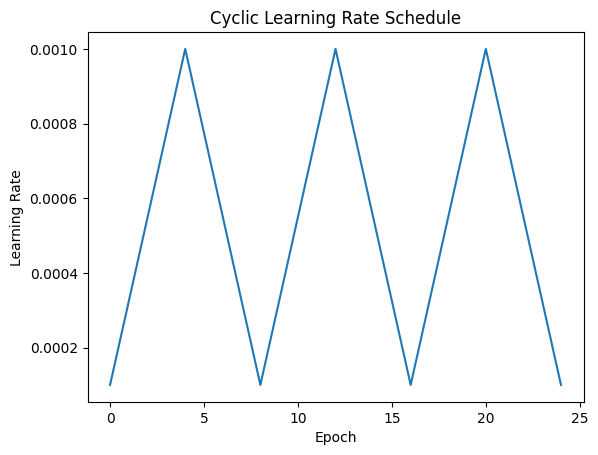

In [69]:
#Visualizar como varia el learning_rate durante el entrenamiento

lrs = history.history['learning_rate']
plt.plot(lrs)
plt.title('Cyclic Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [70]:
#Claves exactas que se podra usar para acceder a las métricas y al learning_rate
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [71]:
#RESULTADOS
print("Obtained results with CNN-LSTM-MLP-CyclicLR Model")
train_test_accuracy(cnn_lstm_mlp_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM-MLP-CyclicLR Model
Train accuracy: 99.81
Test accuracy: 84.50


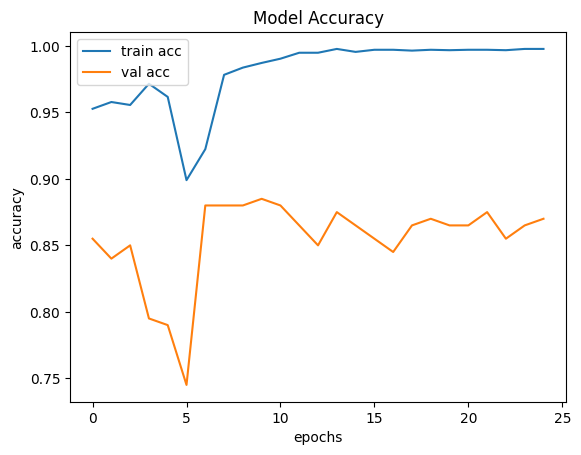

In [72]:
#plot accuracy
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

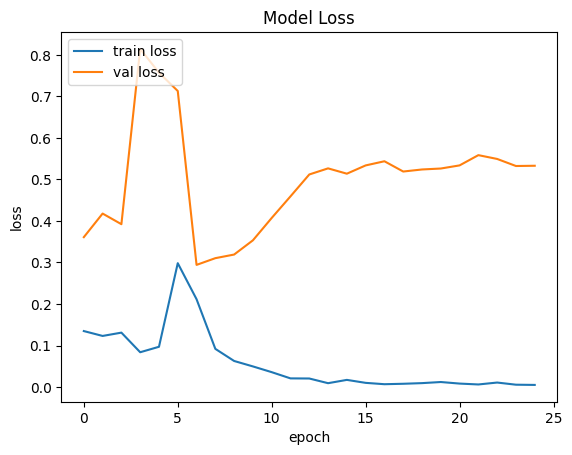

In [73]:
#plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step
Reporte de métricas
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       351
           1       0.83      0.86      0.84       333

    accuracy                           0.85       684
   macro avg       0.85      0.85      0.85       684
weighted avg       0.85      0.85      0.85       684

accuracy: 0.845


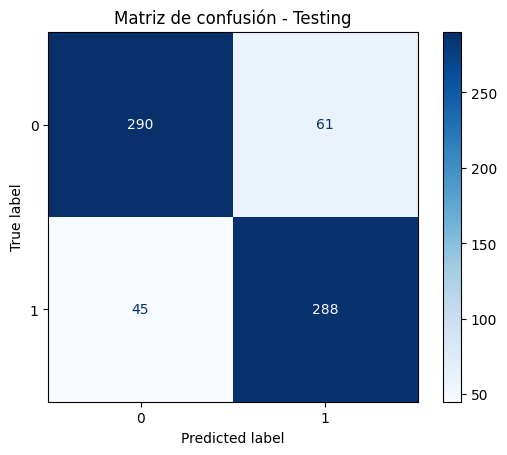

Predicciones guardadas en 'predictions_testing_cnn_lstm_mlp.csv'
     Id                                              Texto      Fecha  \
0   191  lima sur desde defensoriaperu demandamos respe... 2020-12-03   
1  1122  elecciones2021 el 10 de febrero es la fecha lí... 2021-01-02   
2  2103  onpeinforma a partir de ahora compartiremos en... 2021-04-13   
3  3639  último los titulares del jne la onpeoficial y ... 2021-03-24   
4  1228  elecciones2021 lescano dice que sube en encues... 2021-03-01   

   Etiqueta Real  Etiqueta Predicha  
0              1                  1  
1              1                  1  
2              1                  1  
3              1                  1  
4              1                  0  


In [74]:
#Resultados
df_resultados_cnn_lstm_mlp = reporte_clasificacion(cnn_lstm_mlp_model, test_padded, Y_test)
print(df_resultados_cnn_lstm_mlp.head())

#### Guardamos el modelo final:

In [75]:
cnn_lstm_mlp_model.save('final_model.keras')
print("Modelo final guardado exitosamente")

Modelo final guardado exitosamente


#### Interpretacion de estos mejores resultados

- Precision y Recall balanceados:
La precisión y recall están bastante equilibradas para ambas clases, lo que indica que el modelo no está favoreciendo una clase sobre la otra.
- F1-Score alto:
Un F1-Score de 0.85 y 0.84 indica que el modelo está logrando un buen balance entre precision y exhaustividad.
- Macro y Weighted Avg:
La media macro y ponderada (0.85) confirma que el rendimiento del modelo es consistente en ambas clases.


## Generar el dataframe con el best_cnn_lst_mlp_cyclicLR.keras

### Cargar el best_model

In [76]:
from tensorflow.keras.models import load_model

In [83]:
best_model = load_model('best_cnn_lst_mlp_cyclicLR.keras')
print("Best model cargado exitosamente")

Best model cargado exitosamente


### Realizar las predicciones con el best_model

In [84]:
#Función para calcular la PREDICCION con el best_model generado durante el entrenamiento

def reporte_clasificacion_best_model(model,test_padded,Y_test):
  model = best_model
  y_actuals = np.argmax(Y_test, axis=1) # Convertir Y_test a etiquetas

  #encoder.inverse_transform(a)
  y_preds = model.predict(test_padded)

  prediction_ = np.argmax(y_preds, axis=1) #Convertir predicciones a etiquetas

  y_preds = prediction_
  target_names = ['0', '1']
  report = classification_report(y_actuals.tolist(), y_preds.tolist(), target_names=target_names)
  print("Reporte de métricas")
  print(report)
  print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_actuals.tolist(), y_preds.tolist())))

  #Calcular la matriz de confusión
  cm = confusion_matrix(y_actuals, prediction_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

  #Visualizar y guardar la matriz de confusión
  disp.plot(cmap='Blues')
  plt.title("Matriz de confusión - Testing")
  plt.savefig("Matriz_confusion_testing.png")
  plt.show()

  #Decodificar las secuencias vectorizadas de los textos a los textos originales
  X_test_texts = [' '.join(tokenizer.index_word.get(word, '') for word in sequence if word !=0) for sequence in test_padded]

  #Crear el dataframe con las predicciones
  df_predictions = pd.DataFrame({
      'Id': df_testing.Id,
      'Texto': X_test_texts,
      'Fecha': df_testing.Fecha,
      'Etiqueta Real': y_actuals,
      'Etiqueta Predicha': prediction_
  }

  )

  #Guardar el dataframe a un archivos csv
  df_predictions.to_csv('predictions_testing_best_model.csv', index=False)
  print("Predicciones guardadas en 'predictions_testing_best_model.csv'")

  return df_predictions

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step
Reporte de métricas
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       351
           1       0.84      0.88      0.86       333

    accuracy                           0.86       684
   macro avg       0.86      0.86      0.86       684
weighted avg       0.86      0.86      0.86       684

accuracy: 0.858


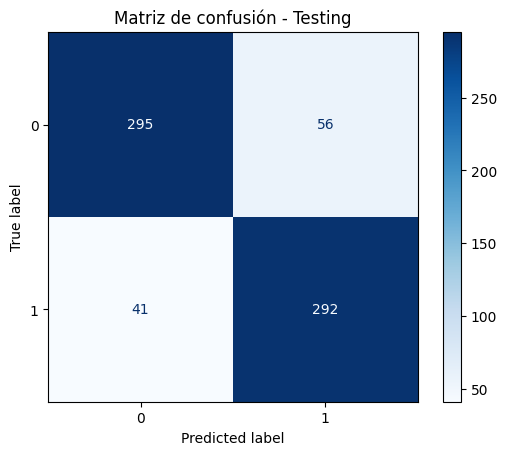

Predicciones guardadas en 'predictions_testing_best_model.csv'
     Id                                              Texto      Fecha  \
0   191  lima sur desde defensoriaperu demandamos respe... 2020-12-03   
1  1122  elecciones2021 el 10 de febrero es la fecha lí... 2021-01-02   
2  2103  onpeinforma a partir de ahora compartiremos en... 2021-04-13   
3  3639  último los titulares del jne la onpeoficial y ... 2021-03-24   
4  1228  elecciones2021 lescano dice que sube en encues... 2021-03-01   

   Etiqueta Real  Etiqueta Predicha  
0              1                  1  
1              1                  1  
2              1                  1  
3              1                  1  
4              1                  0  


In [85]:
#Resultados de best model
df_resultados_best_model = reporte_clasificacion_best_model(best_model, test_padded, Y_test)
print(df_resultados_best_model.head())

In [86]:
#RESULTADOS
print("Obtained results with CNN-LSTM-MLP-CyclicLR Model")
train_test_accuracy(best_model, train_padded, Y_train, test_padded, Y_test)

Obtained results with CNN-LSTM-MLP-CyclicLR Model
Train accuracy: 98.98
Test accuracy: 85.82
